## This notebook has 5 coding questions based on langgraph.

In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("groq_key")


In [2]:
! pip install langchain langgraph langchain-groq langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.66
    Uninstalling langchain-core-0.3.66:
      Successfully uninstalled langchain-core-0.3.66


In [3]:
import os
if not os.environ.get("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = secret_value_0

from langchain.chat_models import init_chat_model
llm = init_chat_model(model = "llama3-8b-8192", model_provider="groq")

## Question 1: 
Write a simple LangGraph with two nodes:

* A user_input node that accepts a string.

* A llm_response node that uses Groq to generate a response based on the input.

The flow should:

* Start from user_input → go to llm_response → and return the final result.

📌 Constraints:

* Input should be "Tell me a joke".

In [4]:
from langchain_core.prompts import PromptTemplate
prompt = PromptTemplate(
    input_variables = ['input'],
    template = "Reply to this query.\n\n{input}"
)

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import START,StateGraph
class State(TypedDict):
    question: str
    result: str


def user_input(state:State):
    """Takes user input"""
    input_str = "Tell me a joke"
    user_prompt = prompt.format(input=input_str)
    return {"question":user_prompt}

def llm_response(state:State):
    """LLM responding to the question"""
    response = llm.invoke(state['question'])
    return {"result":response.content}

graph_builder = StateGraph(State).add_sequence([user_input,llm_response])
graph_builder.add_edge(START,"user_input")
graph = graph_builder.compile()

In [6]:
final_result = graph.invoke({})
print(final_result['result'])

Here's one:

Why couldn't the bicycle stand up by itself?

Because it was two-tired!

Hope that made you smile!


# Question 2:
You are building a LangGraph that translates a sentence from English to French using Groq's llama3-8b-8192 model.
You need to build a 3-node graph:

* A node to accept English input from the user.

* A node to create a prompt for translation.

* A node that gets the translated French sentence from the LLM.

In [7]:
from typing_extensions import TypedDict
class State(TypedDict):
    """Defining State for our graph"""
    question: str
    prompt: str
    result: str

def inputs(state:State) -> State:
    """This input formats input."""
    inputs = "Where is the nearest train station?"
    return {"question":inputs}

def create_prompts(state:State) -> State:
    """Generates prompt."""
    prompt = f"Translate this sentence into French:\n\n{state['question']}"
    return {"prompt": prompt}

def translate_to_French(state:State) -> State:
    """Return French translation of English sentence."""
    result = llm.invoke(state['prompt'])
    return {"result": result.content}

graph_builder = StateGraph(State).add_sequence([inputs,create_prompts,translate_to_French])
graph_builder.add_edge(START,"inputs")
graph = graph_builder.compile()

graph.invoke({})

{'question': 'Where is the nearest train station?',
 'prompt': 'Translate this sentence into French:\n\nWhere is the nearest train station?',
 'result': 'La traduction de la phrase est :\n\n"Où est la gare de train la plus proche ?"\n\nHere\'s a breakdown of the translation:\n\n* "Where" is translated to "Où"\n* "is" is implied by the verb "est" in the sentence\n* "the" is translated to "la" (since the noun "gare" is feminine)\n* "nearest" is translated to "la plus proche"\n* "train station" is translated to "gare de train"'}

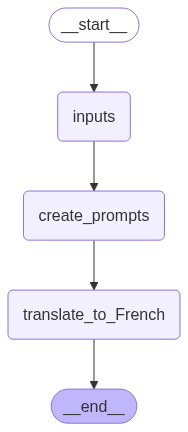

In [8]:
from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))

### Question 3:

You're building a LangGraph workflow that uses LangChain tools.

You want to:

* Accept a user's question (e.g., "Show me all employees in the Sales department"),

* Generate a SQL query from it using an LLM,

* Execute the SQL query using a tool (QuerySQLDatabaseTool), and

* Return the final result.

In [9]:
from langchain_community.utilities import SQLDatabase
db=SQLDatabase.from_uri("sqlite:////kaggle/input/chinook/Chinook_Sqlite.sqlite")
print(db.dialect)
print(db.get_usable_table_names())


sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
